# SDSS DR14 classification using neural networks

Having previously explored how to classify the celestial objects from this data set using a decision tree, we will now look at a neural network (NN) approach and compare the two approaches.

# Installing necessary libraries

Once again we begin by installing the libraries that we require to build our NN.
Generally, the main library used for building these NNs is `TensorFlow`, but here we will be using `PyTorch` as here we can take a more detailed look into what is happeing behind the scenes of the NN.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Loading the dataset

Similarly to before, we will load the dataset as well as exploring the distributions of classes.

In [3]:
data = pd.read_csv('Skyserver_SQL2_27_2018 6_51_39 PM.csv')

We'll now look at the first few rows of the data again, as well as plotting the distributions of the classes in the dataset.

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


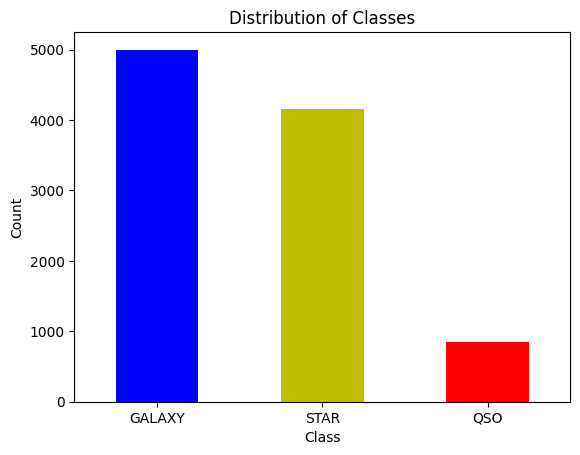

In [5]:
data['class'].value_counts().plot(kind='bar', color=['b', 'y', 'r'])
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

# Preprocessing the data

In this section we will preprocess the data before defining our NN. This will ensure that data is in a form suitable for training the NN effectively. The main steps we will take here are:

- Selecting relevant features
- Encoding target labels
- Normalising features
- Train-Test split
- Converting to tensors

In [15]:
# Selecting only the relevant features
features = ['u', 'g', 'r', 'i', 'z']
X = data[features]
y = data['class']

#Encode the target variables
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

We have seen in the previous notebook: the features that we have selected as well as using `train_test_split`, however there are some new features here.

`label_encoder` assigns numerical values to each of the classes, with `STAR` being `0`, `GALAXY` being `1` and `QSO` being `2`

We also introduce the normalisation of the selected features, this is because each of the magnitudes in the different filters might have different ranges, and NNs are sensitive to the scale of input data, and large differences in feature scales can cause unstable training. By using `StandardScaler`, we ensure that all features have a mean of 0 and a standard deviation of 1 which improves the models performance and training stability.

Furthermore, we also convert the data into tensors. This is because PyTorch operates in tensors and converting the data allows it to be used by PyTorch's data loaders and NN layers.

# Defining  and initialising the neural network

Now that the data has been preprocessed we can move on to building our NN.

In [16]:
class StarGalaxyQuasarClassifier(nn.Module):
    def __init__(self):
        super(StarGalaxyQuasarClassifier, self).__init__()
        self.fc1 = nn.Linear(5, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

This might look complex but we can break down what is happening here.
First we define a custom neural network class, which in our case is name `StarGalaxyQuasarClassifier`. It comes from the `nn.Module` which is the base class for all neural networks in PyTorch.

`__init__` initialses the layers and the components of the network. The `forward` method defines how data flows through the NN when inputs are put through it.

The overall architechture for this NN are as follows:
- Input layer: Take 5 features as an input
- Hidden layers:
-First layer: fully connected with 64 neurons and ReLU activation
- Dropout: Regularizes the model by randomly dropping activations.
- Second layer: Fully connected with 32 neurons and ReLU activation.
- Output layer: Fully connected with 3 neurons, one for each class

With our NN defined we can now initialise it, as well as the loss function and optimiser.

In [17]:
model = StarGalaxyQuasarClassifier()

Now our model is ready to be trained with the dataset!

# Training and evaluating the model

With the newly definied and initialised NN, we can now move onto training our model and evaluating it's performance. We'll look at the loss history of the model over it's epochs, as well as generating a classification report and a confusion matrix.

In [18]:
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train() # Set model into training mode
    loss_history = [] # Create an array to store average loss
    for epoch in range(epochs): # Iterate through the training process
        running_loss = 0.0
        for inputs, labels in train_loader: # loop through train_loader
            optimizer.zero_grad() # Clear gradients from previous epochs
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            loss.backward()
            optimizer.step() # Adjusts moodel's weights based on previous back propagation
            running_loss += loss.item() # Accumulate the loss
        epoch_loss = running_loss / len(train_loader) # Loss for each epoch
        loss_history.append(epoch_loss) # Record the loss
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    return loss_history

A breakdown of what is happening here is listed in te comments, but lets explore what the training function takes as arguments:

- `model`: which is the NN we defined
- `train_loader`: data loader containing the training data and labels
- `criterion`: the loss function used to calculate the error
- `optimizer`: optimisation algorithm which updates the model's weights
- `epochs`: number of training cycles, for simplicity we will keep this at 20

Now we'll set up the training components.


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

`lr` is the learning rate, which determines the size of the steps that the optimiser takes when updating the weights.

if `lr` is too high then it could potentially lead to overshooting the optimal solution. But if it is too low then it could mean that the model will take too long to train.

And then train the model.


In [20]:
loss_history = train_model(model, train_loader, criterion, optimizer, epochs=20)

Epoch 1/20, Loss: 0.7652
Epoch 2/20, Loss: 0.5243
Epoch 3/20, Loss: 0.4257
Epoch 4/20, Loss: 0.3594
Epoch 5/20, Loss: 0.3175
Epoch 6/20, Loss: 0.2971
Epoch 7/20, Loss: 0.2846
Epoch 8/20, Loss: 0.2661
Epoch 9/20, Loss: 0.2622
Epoch 10/20, Loss: 0.2543
Epoch 11/20, Loss: 0.2475
Epoch 12/20, Loss: 0.2500
Epoch 13/20, Loss: 0.2408
Epoch 14/20, Loss: 0.2321
Epoch 15/20, Loss: 0.2278
Epoch 16/20, Loss: 0.2280
Epoch 17/20, Loss: 0.2295
Epoch 18/20, Loss: 0.2272
Epoch 19/20, Loss: 0.2175
Epoch 20/20, Loss: 0.2172


Let's also take a look at the training loss over the epochs.

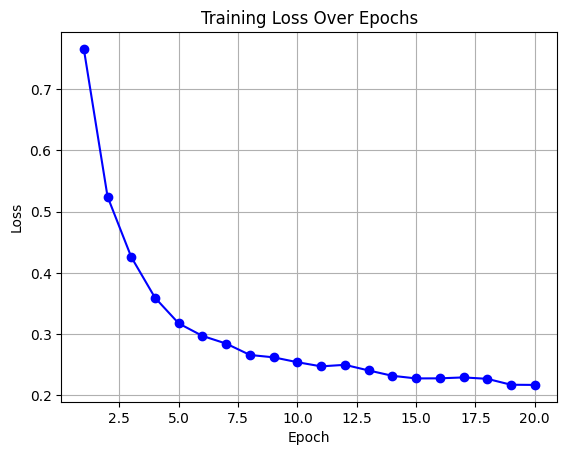

In [21]:
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', color='b')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

Now that the model is trained, we can then evaluate how it performs, as well as printing out a classification report and a confusion matrix.

Accuracy: 93.80%
Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.97      0.92      0.95       996
         QSO       0.91      0.91      0.91       190
        STAR       0.91      0.96      0.93       814

    accuracy                           0.94      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.94      0.94      0.94      2000



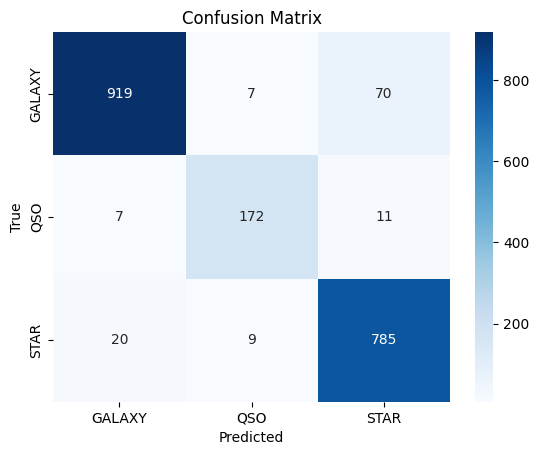

In [22]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

    # Generate classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Evaluate the model
evaluate_model(model, test_loader)

# Comparison with decision tree

Before we conclude this noteboook, let us compare our two approaches to tackling this classification problem.

- **Accuracy**: When we built our decision tree (DT), it had a respectable accuracy of 74%, and without any optimisations or including any dominant features (such as redshift) this is a great result!
However, as we can see, our NN is far more accurate with an impressive accuracy of 93.80%

- **Overall performance**: The NN far outperforms the DT in every aspect here:


1.   **Precision**: Overall the DT had a good precision, with `0.82, 0.83, 0.65` for `GALAXY, QSO, STAR` respectively, but as we see the `STAR` precision is n the lower end. Our NN on the otherhand, boasts and impressive showing of `0.97, 0.90, 0.92` for `GALAXY, QSO, STAR`.
2.   **Recall**: NN performs much better here than our DT. The biggest difference comes in the `GALAXY` class, with a DT recall score of 67% compared to the NN's 92%. The higher recall score for the NN indicates that it was able to identify more true positives than the DT.
3.   **f1 score**: Here the f1 score in the NN ranges from 0.93 to 0.95, whereas the DT has more of a range, being between 0.72 and 0.81. This means that the NN was better across ALL classes, and not just the most numerous class. This is important as there are significantly less quasars than stars and galaxies in this dataset.

- **Practicality**: Overall, if we are looking to maximise the performance of our model, the NN is definitely the way to go - especially if our dataset is large. However, if we have a smaller dataset or if we need some quick,m interpretable results a DT may be used at the cost of some accuracy.



# Conclusion

In this notebook, we have explored how we can build a neural network to tackle this classification problem, as well as looking at the overall performance of the model.

To take this model even further:
- Try experimenting with different architectures (e.g. deeper networks or more neurons etc.)
- Modify hyperparameters such as learning and dropout rates
- Other optimisation alrorithms such as SGD